# Trabajo Final de Estructura 3

## Resolver la ecuacion de Schrödinger con un metodo numerico que usa los polinomios de Chebychev

Nicolas Unger

Para este trabajo me voy a basar en el paper de Rawitscher.

"An efficient numerical spectral method for solving the Schrodinger equation," in Computing in Science & Engineering, vol. 7, no. 6, pp. 58-66, Nov.-Dec. 2005.

El metodo que usa Rawitscher es bastante complicado y me tomo bastante tiempo entender cada paso y asi poder modificar el programa de matlab y aplicarlo a otros casos.

Voy a tratar de dar una descripcion general del metodo sin entrar con mucho detalle en las cuentas.

## Descripcion del metodo

Toda funcion se puede expresar como una combinacion lineal de polinomios de Chebychev en el intervalo [-1,1]

\begin{equation}
f(x) = \frac{a_0}{2} + \sum_{j=1}^{\infty} a_j T_j(x)
\end{equation}

Siendo $T_j(x)$ el polinomio de chebychev de orden $j$.

Se puede mostrar que en esta expansion los valores de $a_j$ convergen muy rapido a $0$ para ordenes mayores de $j$. Esto significa que el error que se comete al cortar la expasion en un dado valor j es muy bajo y no se introducen anomalias como el fenomeno de Gibbs. Entonces se puede escribir nuestra funcion como una expansion truncada:

\begin{equation}
f_N(x) = \frac{a_0}{2} + \sum_{j=1}^{N} a_j T_j(x)
\end{equation}

Para obtener los valores $a_j$ se usan unas matrices $S_L$ y $S_R$ que estan descriptas en el paper y se calculan con la funcion SLSR.m de MATLAB.

La ecuacion de Schrödinger a resolver es: 

\begin{equation}
\left( \frac{d^2}{dr^2} + k^2 \right) \psi = V \psi
\end{equation}

Pero en este caso es mas facil resolver la ecuacion integral equivalente de Lippmann-Schwinger (L-S):

\begin{equation}
\psi(r) = sin(kr) + \int_0^T G_0(r,r')V(r')\psi(r')dr'
\end{equation}

donde $G_0$ es la funcion de Green.

A partir de acá utilizan una version del metodo de S-IEM para resolver la ecuación de L-S.
Consiste en partir el intervalo radial $0<r<T$ en particiones y resolver la ecuacion de L-S para cada una de esas particiones obteniendo dos soluciones especial llamadas $Y(r)$ y $Z(r)$. Estas soluciones se obtienen expandiendolas en terminos de los polinomios de Chebychev. Para esto se usan los ceros del polinomio de Chebychev de orden mas alto, e integrales parciales de estas funciones. Este proceso se hace en los programas C_CM1.m y YZ.m. El tamaño de cada particion se determina con un criterio de convergencia tal que los ultimos terminos de la expansion de $Y(r)$ y $Z(r)$ no superen cierta tolerancia (del orden de 1e-12). De esta forma se van obtiendo los limites inferiores $b_{i-1}$ y superiores $b_i$ de cada particion hasta llegar a un valor limite $T$ predefinido. Estos limites se van obteniendo llamando a la funcion meshiem.m.

Una vez obtenidas las funciones $Y(r)$ y $Z(r)$ para cada particion, la funcion de onda global se arma como una combinacion lineal de Y y Z en cada particion. Es decir:

\begin{equation}
\psi(r) = A_i Y_i(r) + B_i Z_i(r), \quad b_{i-1}\le r \le b_i
\end{equation}

Los valores de $A_i$ y $B_i$ se obtienen teniendo en cuenta que en la funcion de onda global tiene que ser continua en la funcion y en la derivada. Entonces se pega cada particion para que coincidan $\psi$ y la derivada.

## Objetivo

El primer objetivo del trabajo fue entender el metodo y el codigo correspondiente. Despues es modificar el codigo provisto por Rawitscher para poder analizar otros casos y no solo el caso especifico que analizo el.

Para eso tuve que cambiar el potencial del de Morse al de Coulomb, los valores de energia a analizar y tambien crear una funcion que genere la funcion de onda global a partir de las descomposiciones en polinomios de chebychev de $Y(r)$ y $Z(r)$ para cada particion. Todo esto no fue tan facil como suena porque el programa esta escrito de una forma poco legible con nombres de variables bastante confusos y tenia que estar seguro de como funciona el programa antes de cambiar algo para saber que no estoy rompiendo nada.

Tambien optimice el programa original sacando calculos innecesarios y preallocando la memoria de los vectores y matrices para alivianar el trabajo de MATLAB. Con esos simples cambios logre que el programa corra 3 veces mas rapido.

Use el ejemplo que habia hecho en la Guia 2, del espectro continuo de un electron en el atomo de Litio para un numero de onda de k=2.3

In [12]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# Estática
sp.init_printing()
%matplotlib inline

#Definimos los simbolos que vamos a usar.
r = sp.Symbol('r',positive=True)
l = sp.Symbol('l',positive=True,integer=True)
z = sp.Symbol('z',positive=True,integer=True)
k = sp.Symbol('k',positive=True)   # k en lugar de n 

In [13]:
# Función Radial Hidrogénica -- Estados del Continuo (con hipergeométricas)

def R_analytic(k,l,z,r):
    
    a = z/k # Parámetro de Sommerfeld
     
    # Generalización al campo complejo
    nj = 1j*a  
    rho = -2*1j*k*r
   
    # Los continuos se normalizan de otra forma
    rnum = (2*z/nj)**3 * sp.gamma(nj+l+1)
    rden = (sp.gamma(2*l+2))**2 * 2*nj * sp.gamma(nj-l)
    rnorm = sp.sqrt(rnum/rden)

    rfunc = 1j**l * (rho)**l * sp.exp(-rho/2) * sp.hyper((-nj+l+1,),(2*l+2,),(rho))
    return rfunc

In [14]:
# Definición de los vectores a plotear
    
nsize = 1000
xmax = 20.0
xmin = 0.01
x = np.linspace(xmin,xmax,nsize)
psi = np.zeros(nsize,dtype=complex)

In [15]:
# Copiamos el array simbólico a numérico

# Variables de mi funcion
kq = 2.3
lq = 0
zq = 3

for i in range(nsize):
    psi[i]= R_analytic(kq,lq,zq,x[i]).evalf()
    
# Creo mi funcion de onda analytica
psi_analytic = R_analytic(kq,lq,zq,r)

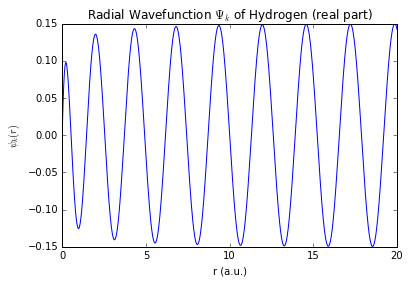

In [16]:
# Ploteo
plt.plot(x,x*psi.real);
plt.title("Radial Wavefunction $\Psi_{k}$ of Hydrogen (real part)");
plt.xlabel("r (a.u.)");
plt.ylabel("$\psi_{k}(r)$");
plt.show()

## Hago lo mismo pero con el metodo espectral de Rawitscher

Calculo fue hecho en MATLAB basandome en el programa provisto por Rawitscher. Importo aca las soluciones de la ecuacion de onda.

Use las mismas condiciones:
k = 2.3;
z = 3;
l = 0;

In [45]:
# Importo los datos obtenidos con el programa de MATLAB

psi_mat = np.loadtxt('psi_k23_C.csv', delimiter=',')
            
r_mat = np.loadtxt('r_k23_C.csv', delimiter=',')

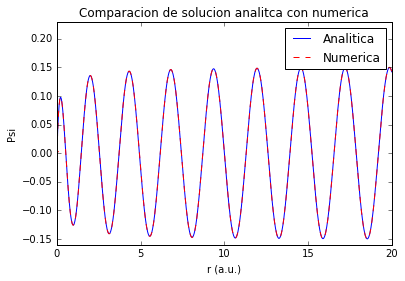

In [56]:
c = 0.423

plt.plot(x,x*psi.real, label='Analitica')
plt.plot(r_mat,c*psi_mat,'r--', label='Numerica')

plt.title("Comparacion de solucion analitca con numerica")
plt.ylim([-0.16,0.23])
plt.xlabel('r (a.u.)')
plt.ylabel('Psi')
plt.legend()
plt.show()

A menos de una constante multiplicativa coinciden muy bien. Se debe a la normalizacion y por algunos parametros numericos coomo la distancia inicial. Use $r=0.002$ como primer dato ya que no puedo usar $r=0$ por la indefinicion del potencial de coulomb.